## [An Easy Guide to build new TensorFlow Datasets and Estimator with Keras Model](https://www.dlology.com/blog/an-easy-guide-to-build-new-tensorflow-datasets-and-estimator-with-keras-model/)
Import packages,
realize how we import keras from tensorflow 

`tensorflow.keras`


In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np

import os
import shutil

tf.__version__

'1.13.1'

## Build Keras model
We are leveraging the pre-trained VGG16 model's convolution layers. aka the "convolutional base" of the model. Then we add our own classifier fully connected layers to do binary classification(cat vs dog). 

Note that since we don't want to touch the parameters pre-trained in the "convolutional base", so we set them as not trainable. Want to go deeper how this model works? Check out this great [jupyter notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb) by the creator of Keras.

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [4]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

## Keras model to TF estimator
`model_dir` will be our location to store trained tensorflow models. Training progress can be viewed by TensorBoard.

I found that I have to specify the full path, otherwise, Tensorflow will complain about it later during training.

In [5]:
model_dir = os.path.join(os.getcwd(), "models//catvsdog").replace("//", "\\")
os.makedirs(model_dir, exist_ok=True)
print("model_dir: ", model_dir)
est_catvsdog = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                     model_dir=model_dir)

model_dir:  E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog
INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_eval_distribute': None, '_master': '', '_model_dir': 'E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog', '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_is_chief': True, '_service': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_task_id': 0, '_device_fn': None, '_protocol': None, '_train_distribute': None, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.tr

The input_name is the model's input layer name, we will need it later when building Input function for your estimator. More on that in Input function section below.

In [6]:
# input layer name
input_name = model.input_names[0]
input_name

'vgg16_input'

## Downloading the data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision 
competition in late 2013. You can download the original dataset at 
https://www.kaggle.com/c/dogs-vs-cats/download/train.zip (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, and a test set with 500 samples of each class.

In [7]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'E:\\Learning_Resources\\Deep_learning\\my_data_sets\\DATASETS_IMAGE\\dog_vs_cat\\train'

# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [8]:
if not os.path.isdir(train_dir) and not os.path.isdir(test_dir):
    os.makedirs(base_dir, exist_ok=True)
    # Directories for our training,
    # validation and test splits
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    # Directory with our training cat pictures
    os.mkdir(train_cats_dir)
    # Directory with our training dog pictures
    os.mkdir(train_dogs_dir)
    # Directory with our validation cat pictures
    os.mkdir(test_cats_dir)
    # Directory with our validation dog pictures
    os.mkdir(test_dogs_dir)
    # Copy first 1000 cat images to train_cats_dir
    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)
    # Copy first 1000 dog images to train_dogs_dir
    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

    # Copy next 500 cat images to test_cats_dir
    fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

    # Copy next 500 dog images to test_dogs_dir
    fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/test):

In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total test cat images: 500
total test dog images: 500


Function to shuffle images along with the labels

In [10]:
def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Collect and shuffle image files with associated labels.

In [11]:
CAT_LABEL = 0
DOG_LABEL = 1
train_cats = [os.path.join(train_cats_dir, file_name)
              for file_name in os.listdir(train_cats_dir)]
train_dogs = [os.path.join(train_dogs_dir, file_name)
              for file_name in os.listdir(train_dogs_dir)]
train_files = train_cats + train_dogs
train_labels = [CAT_LABEL]*len(train_cats)+[DOG_LABEL]*len(train_dogs)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_cats = [os.path.join(test_cats_dir, file_name)
             for file_name in os.listdir(test_cats_dir)]
test_dogs = [os.path.join(test_dogs_dir, file_name)
             for file_name in os.listdir(test_dogs_dir)]
test_files = test_cats + test_dogs
test_labels = [CAT_LABEL]*len(test_cats)+[DOG_LABEL]*len(test_dogs)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

Have a look at first 10 shuffled image files and labels.

In [12]:
print(train_files[:10])
print(train_labels[:10])

['./data/dog_vs_cat_small\\train\\dogs\\dog.497.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.931.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.957.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.161.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.132.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.926.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.998.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.948.jpg'
 './data/dog_vs_cat_small\\train\\dogs\\dog.192.jpg'
 './data/dog_vs_cat_small\\train\\cats\\cat.439.jpg']
[1 0 0 1 1 1 0 1 1 0]


## Input function
When we train our model, we'll need a function that reads the input image files/labels and returns the image data and labels. Estimators require that you create a function of the following format:
````
def input_fn():
    ...<code>...
    return ({ 'input_1':[ImagesValues]},
            [ImageTypeLogit])
```
The return value must be a two-element tuple organized as follows: :

- The first element must be a dictionary in which each input feature is a key, and then a list of values for the training batch.
- The second element is a list of labels for the training batch.
### Arguments
- **filenames**, an array of image file names
- **labels=None**, an array of the image labels for the model. Set to None for inference
- **perform_shuffle=False**, useful when training, reads batch_size records, then shuffles (randomizes) their order.
- **repeat_count=1**, useful when training, repeat the input data several times for each epoch
- **batch_size=1**, reads batch_size records at a time

In [13]:
def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [150, 150])
        image = tf.subtract(image, 116.779)  # Zero-center by mean pixel
        image.set_shape([150, 150, 3])
        image = tf.reverse(image, axis=[2])  # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    if labels is None:
        labels = [0]*len(filenames)
    labels = np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

## Look at the input function output
Looks like color channels 'RGB' has changed to 'BGR' and shape resized to (150, 150) correctly for our model. That is the input format the VGG16's "convolutional base" is expecting.

(20, 150, 150, 3)


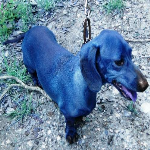

In [14]:
next_batch = imgs_input_fn(
    test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0][input_name]

print(x_d.shape)
img = image.array_to_img(x_d[8])
img

Here is the first batch's labels.

In [15]:
first_batch[1]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

## Training the model
Estimators require an `input_fn` with no arguments, so we create a function with no arguments using lambda. Suggested you should only attempt it if you have access to a GPU, it only takes couple minutes.

In [16]:
# Train our model, use the previously function imgs_input_fn
# Input to training is a file with training example
# Stop training after "repeat_count" iterations of train data (epochs)
est_catvsdog.train(
    input_fn=lambda: imgs_input_fn(test_files,
                                   labels=test_labels,
                                   perform_shuffle=True,
                                   repeat_count=5,
                                   batch_size=20))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog\\keras\\keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: training/RMSprop/Variable_17; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/RMSprop/Variable_13; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: block1_conv2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: block3_conv1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/RMSprop/Variable_25; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: block5_conv1/bias; prev_

## Evaluate
Evaluate our model using the examples contained in test_files and test_labels

Return value will contain evaluation_metrics such as: loss & average_loss

In [17]:
evaluate_results = est_catvsdog.evaluate(
    input_fn=lambda: imgs_input_fn(test_files,
                                   labels=test_labels,
                                   perform_shuffle=False,
                                   batch_size=1))
print("Evaluation results")
for key in evaluate_results:
    print("   {}, was: {}".format(key, evaluate_results[key]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Starting evaluation at 2019-05-29T02:22:49Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog\model.ckpt-251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-29-02:22:57
INFO:tensorflow:Saving dict for global step 251: binary_accuracy = 0.977, global_step = 251, loss = 0.08478442
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 251: E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog\model.ckpt-251
Evaluation results
   global_step, was: 251
   loss, was: 0.08478441834449768
   binary_accuracy, was: 0.9769999980926514


## Predict
To predict we can set the `labels` to None because that is what we will be predicting.

Here we only predict the first 10 images in the test_files.

In [18]:
predict_results = est_catvsdog.predict(
    input_fn=lambda: imgs_input_fn(test_files[:10],
                                   labels=None,
                                   perform_shuffle=False,
                                   batch_size=10))

In [19]:
predict_logits = []
for prediction in predict_results:
    output_name = list(prediction.keys())[-1]
    predict_logits.append(prediction[output_name][0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog\model.ckpt-251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Check the prediction result
The model correctly classified all 10 images.

In [20]:
predict_is_dog = [logit > 0.5 for logit in predict_logits]
actual_is_dog = [label > 0.5 for label in test_labels[:10]]
print("Predict dog:", predict_is_dog)
print("Actual dog :", actual_is_dog)

Predict dog: [True, True, False, True, False, False, True, False, False, False]
Actual dog : [True, True, False, True, False, False, True, False, False, False]


### tf.estimator.train_and_evaluate

Since TensorFlow release 1.4 also introduces the utility function **tf.estimator.train_and_evaluate**, which simplifies training, evaluation, and exporting Estimator models. This function enables distributed execution for training and evaluation, while still supporting local execution.

Notice that the train was build on previous training result when we call the `est_catvsdog.train()`

In [24]:
# Train for another 500 steps.
train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(test_files,
                                                                   labels=test_labels,
                                                                   perform_shuffle=True,
                                                                   repeat_count=5,
                                                                   batch_size=20),
                                    max_steps=500 + 500)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(test_files,
                                                                 labels=test_labels,
                                                                 perform_shuffle=False,
                                                                 batch_size=1))
import time
start_time = time.time()
tf.estimator.train_and_evaluate(est_catvsdog, train_spec, eval_spec)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('E:\\SW_WS\\Python_SW\\Keras_catVSdog_tf_estimator\\models\\catvsdog\\keras\\keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: training/RMSprop/Variable_17; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/RMSprop/Variable_13; prev_var_n

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: E:\SW_WS\Python_SW\Keras_catVSdog_tf_estimator\models\catvsdog\model.ckpt-1000
INFO:tensorflow:Loss for final step: 1.1248606e-07.
--- 62.12470269203186 seconds ---
